In [56]:
# Imports, as always...
from pathlib import Path
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import torch

from torch.nn import Sequential, Linear, ReLU, BatchNorm1d, Dropout, Softmax, LogSoftmax
from torch.nn import CrossEntropyLoss, BCEWithLogitsLoss, KLDivLoss
from scripts.training import train, evaluate

from sklearn.model_selection import train_test_split as tts
from torch.utils.data import DataLoader
from scripts.data import QuantumDataset

import warnings
warnings.filterwarnings('ignore')

seed = 42
torch.random.manual_seed(seed)

test_split, val_split = .2, .2

device = 'cuda' if torch.cuda.is_available() else 'cpu'

import matplotlib.pyplot as plt
import seaborn as sns
palette = 'deep'
sns.set_theme(style='darkgrid', palette=palette)

In [2]:
# Raw data.
raw_data = pd.concat([
    pd.read_csv(data_csv) 
    for data_csv in Path('./data/depth-varied').glob('*.csv')
], ignore_index=True)

# Subset for between devices of the same type:
subset_same = raw_data[raw_data['device'] != 'Aria-1'].replace({'Ankaa-3':0, 'Garnet':1})
# Subset for between devices of differing type:
subset_diff = raw_data[raw_data['device'] != 'Garnet'].replace({'Ankaa-3':0, 'Aria-1':1})

In [3]:
# Helper function to create a balanced subset for two devices.
def stratified_sample(df, n, device_a_label=0, device_b_label=1, random_state=None):
    # Split into device 0 and device 1.
    df_0 = df[df['device'] == device_a_label]
    df_1 = df[df['device'] == device_b_label]
    
    # Too large an n?
    assert n <= len(df_0) and n <= len(df_1), 'n must be smaller than each dataset.'

    # Sample.
    sample_0 = df_0.sample(n=n, random_state=random_state)
    sample_1 = df_1.sample(n=n, random_state=random_state)
    
    # Combine and shuffle the result
    result = pd.concat([sample_0, sample_1]).sample(frac=1, random_state=random_state).reset_index(drop=True)
    
    return result

## Same-type Classification

In [5]:
def binary_model_experiment(all_data_df, feature_type, in_features = 32, batch_size = 32, verbose = False):
    # Splitting.
    train_df, test_df = tts(all_data_df, test_size=test_split, shuffle=True, random_state=seed)
    train_df, val_df = tts(train_df, test_size=val_split, shuffle=True, random_state=seed)
    
    # Datasets and Dataloaders.
    train_set = QuantumDataset(train_df, feature_type)
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_set = QuantumDataset(val_df, feature_type)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
    test_set = QuantumDataset(test_df, feature_type)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
    
    # Model.
    model = Sequential(
        Linear(in_features, 64), BatchNorm1d(64), ReLU(), #Dropout(.5),
        Linear(64, 16), BatchNorm1d(16), ReLU(), #Dropout(.5),
        Linear(16, train_df['device'].nunique())
    )
    model.to(device)
    
    # Train.
    train_losses, train_accs, val_losses, val_accs = train(model, device, BCEWithLogitsLoss(), train_loader, val_loader, n_epochs=100, lr=1e-3, weight_decay=1e-4, verbose=verbose)
    
    if verbose:
        # Set up a figure and axes.
        fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(8, 3))
        
        # Plot the stats.
        epochs = np.arange(len(train_losses))
        sns.lineplot(x=epochs, y=train_losses, ax=ax_loss)
        sns.lineplot(x=epochs, y=val_losses, ax=ax_loss)
        sns.lineplot(x=epochs, y=train_accs, ax=ax_acc, label='Train')
        sns.lineplot(x=epochs, y=val_accs, ax=ax_acc, label='Val')
        
        # Beautification.
        ax_loss.set_title('Loss')
        ax_loss.set_xlabel('Epoch')
        
        ax_acc.set_title('Accuracy')
        ax_acc.set_xlabel('Epoch')
        
        plt.show()
    
    # Evaluate.
    test_acc = evaluate(model, device, test_loader, BCEWithLogitsLoss())[-1]
    
    return max(train_accs), max(val_accs), test_acc

In [36]:
binary_model_experiment(subset_same[subset_same['d'] < 25], 'raw', verbose=True)

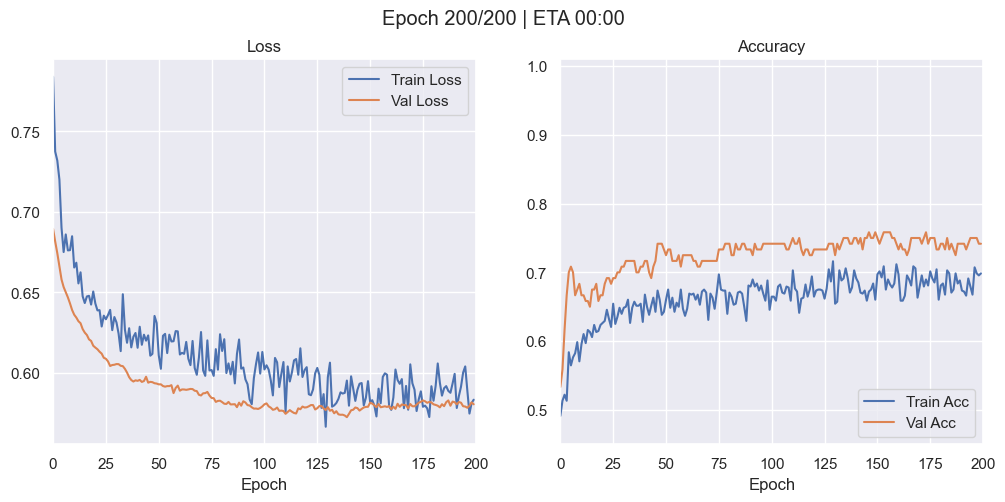

Epoch 200/200 | Train Loss: 0.5834 | Train Acc: 0.6985 | Val Loss: 0.5805 | Val Acc: 0.7417


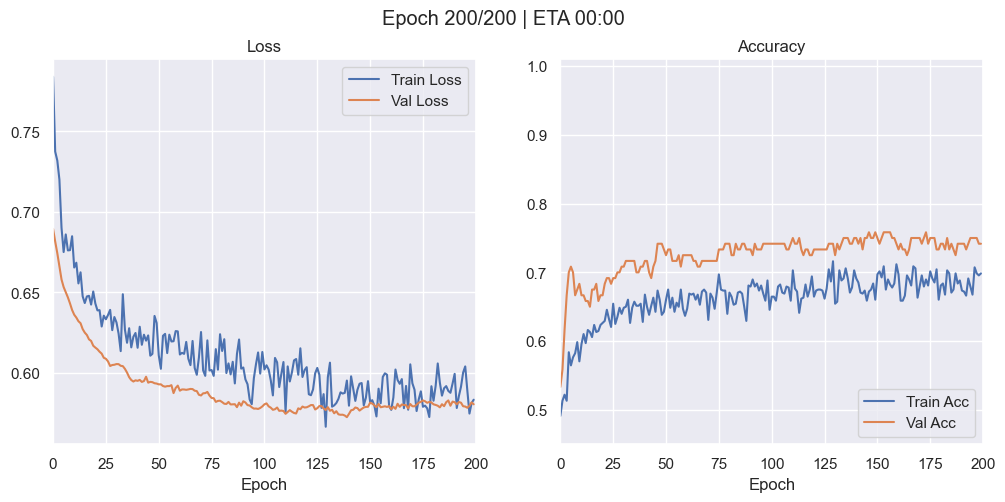

In [135]:
binary_model_experiment(subset_same[subset_same['d'] < 25], 'res', verbose=True)

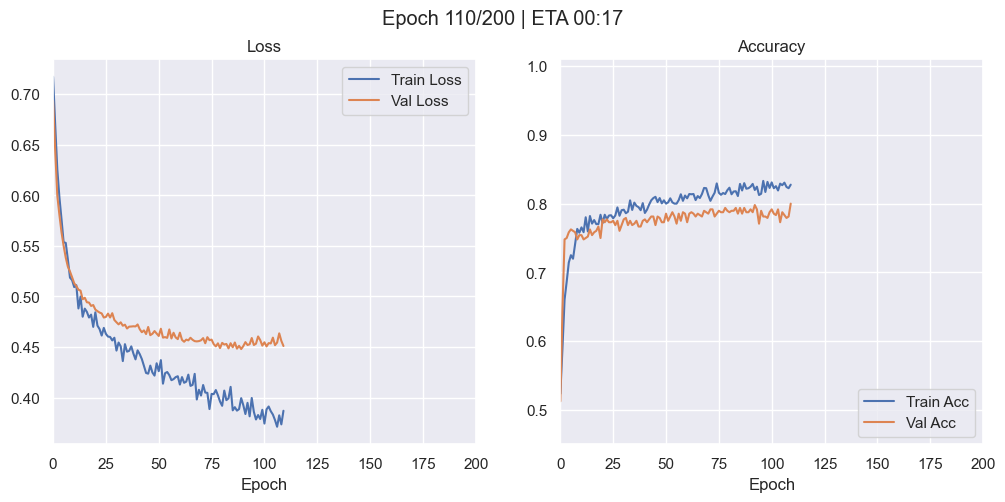

Epoch 110/200 | Train Loss: 0.3869 | Train Acc: 0.8276 | Val Loss: 0.4510 | Val Acc: 0.8000


(0.4158059275150299, 0.81125)

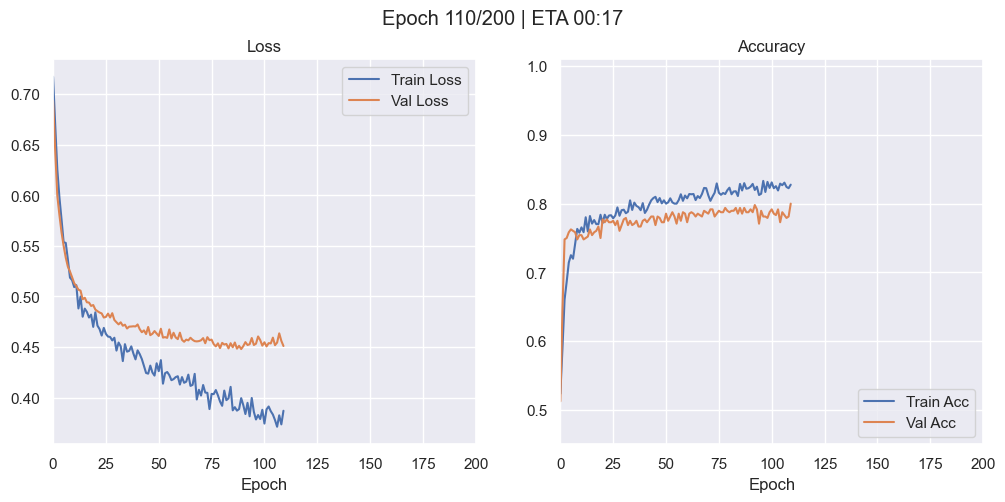

In [47]:
binary_model_experiment(subset_same[subset_same['d'] < 25], 'abs_res', verbose=True)

In [49]:
binary_model_experiment(subset_same[subset_same['d'] < 25], 'rel_res', verbose=True)

In [54]:
binary_model_experiment(subset_same[subset_same['d'] < 25], 'abs_rel_res', verbose=True)

  0%|          | 0/10 [00:00<?, ?it/s]

In [55]:
binary_model_experiment(subset_same[subset_same['d'] < 25], 'log_ratio', verbose=True)

({'raw': {5: (0.951470587534063, 0.900000023841858, 0.88),
   10: (0.972058824931874, 0.9416666825612386, 0.895),
   15: (0.9588235294117647, 0.9000000317891439, 0.885),
   20: (0.923529412465937, 0.8583333492279053, 0.86)},
  'res': {5: (0.8397058823529412, 0.7333333571751912, 0.695),
   10: (0.7632352934164159, 0.6916666746139526, 0.555),
   15: (0.7000000014024622, 0.5583333571751913, 0.57),
   20: (0.6485294138683992, 0.6, 0.605)},
  'abs_res': {5: (0.8676470595247605, 0.7166666785875956, 0.67),
   10: (0.6852941197507522, 0.6333333611488342, 0.61),
   15: (0.6867647051811219, 0.575000015894572, 0.505),
   20: (0.6044117661083446, 0.575000011920929, 0.41)},
  'rel_res': {5: (0.5926470602259917, 0.5333333333333333, 0.515),
   10: (0.575, 0.6083333571751912, 0.535),
   15: (0.573529412465937, 0.5333333492279053, 0.535),
   20: (0.5720588242306429, 0.6166666905085246, 0.45)},
  'abs_rel_res': {5: (0.6000000014024622, 0.5583333532015483, 0.535),
   10: (0.5764705882352941, 0.5916666666

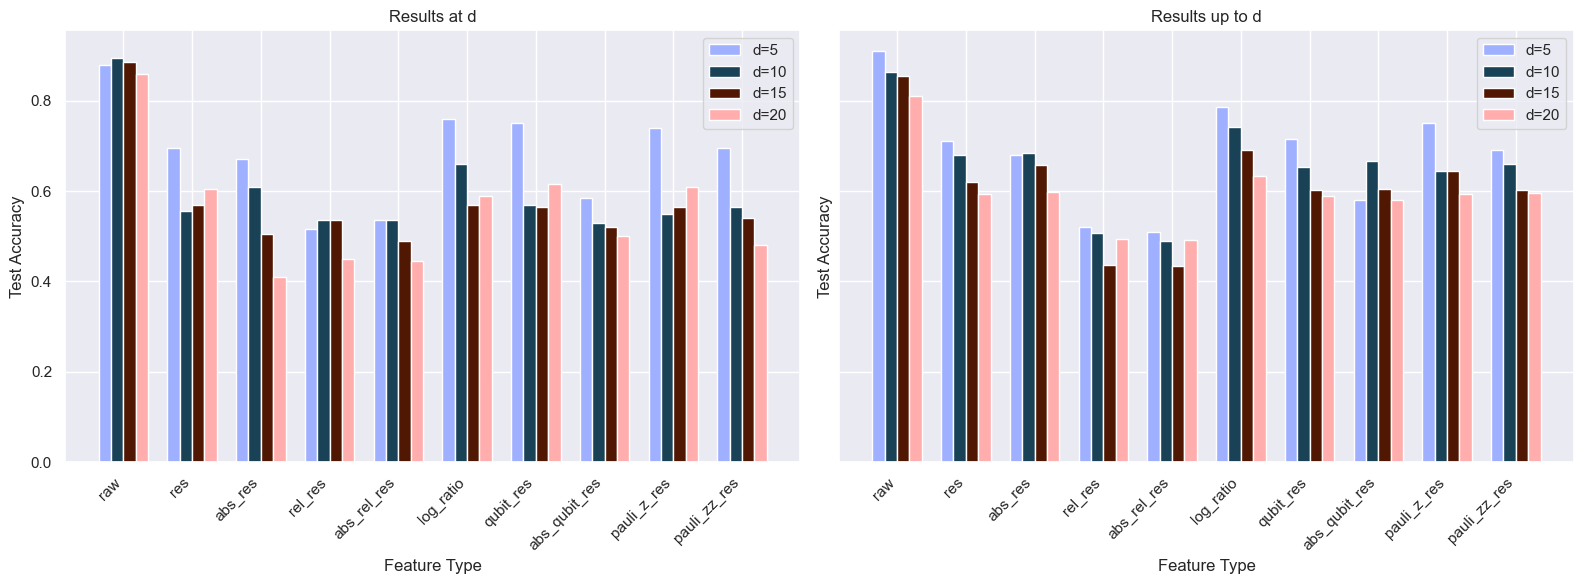

In [59]:
binary_model_experiment(subset_same[subset_same['d'] < 25], 'qubit_res', 5, verbose=True)

Top-level training:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 010: train loss - 0.671, val loss - 0.763, train acc - 0.587, val acc - 0.430
Epoch 020: train loss - 0.662, val loss - 0.763, train acc - 0.600, val acc - 0.441
Epoch 030: train loss - 0.657, val loss - 0.771, train acc - 0.607, val acc - 0.444
Epoch 040: train loss - 0.655, val loss - 0.798, train acc - 0.618, val acc - 0.445
Epoch 050: train loss - 0.652, val loss - 0.824, train acc - 0.613, val acc - 0.456
Epoch 060: train loss - 0.651, val loss - 0.804, train acc - 0.618, val acc - 0.442
Epoch 070: train loss - 0.650, val loss - 0.803, train acc - 0.611, val acc - 0.458
Epoch 080: train loss - 0.650, val loss - 0.813, train acc - 0.610, val acc - 0.445
Epoch 090: train loss - 0.644, val loss - 0.782, train acc - 0.627, val acc - 0.456
Epoch 100: train loss - 0.638, val loss - 0.822, train acc - 0.625, val acc - 0.444


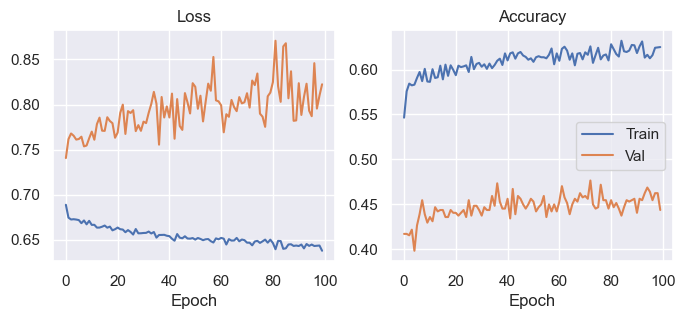

(0.63203125, 0.4765625, 0.41375)

In [22]:
binary_model_experiment(subset_same[subset_same['d'] < 25], 'abs_qubit_res', 5, verbose=True)

Top-level training:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 010: train loss - 0.648, val loss - 0.864, train acc - 0.616, val acc - 0.438
Epoch 020: train loss - 0.643, val loss - 0.888, train acc - 0.621, val acc - 0.439
Epoch 030: train loss - 0.637, val loss - 0.906, train acc - 0.624, val acc - 0.420
Epoch 040: train loss - 0.631, val loss - 0.914, train acc - 0.631, val acc - 0.442
Epoch 050: train loss - 0.632, val loss - 0.891, train acc - 0.637, val acc - 0.427
Epoch 060: train loss - 0.628, val loss - 0.948, train acc - 0.648, val acc - 0.444
Epoch 070: train loss - 0.623, val loss - 0.939, train acc - 0.643, val acc - 0.442
Epoch 080: train loss - 0.620, val loss - 0.937, train acc - 0.639, val acc - 0.444
Epoch 090: train loss - 0.615, val loss - 1.006, train acc - 0.648, val acc - 0.438
Epoch 100: train loss - 0.618, val loss - 0.996, train acc - 0.645, val acc - 0.434


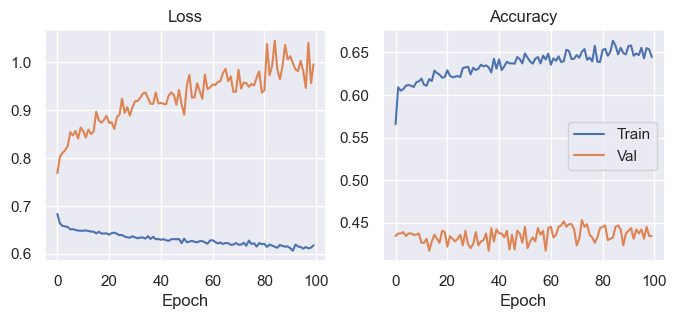

(0.663671875, 0.453125, 0.3875)

In [23]:
binary_model_experiment(subset_same[subset_same['d'] < 25], 'pauli_z_res', 5, verbose=True)

Top-level training:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 010: train loss - 0.658, val loss - 0.749, train acc - 0.605, val acc - 0.464
Epoch 020: train loss - 0.631, val loss - 0.784, train acc - 0.631, val acc - 0.458
Epoch 030: train loss - 0.609, val loss - 0.799, train acc - 0.666, val acc - 0.445
Epoch 040: train loss - 0.593, val loss - 0.814, train acc - 0.676, val acc - 0.463
Epoch 050: train loss - 0.577, val loss - 0.843, train acc - 0.690, val acc - 0.473
Epoch 060: train loss - 0.562, val loss - 0.845, train acc - 0.701, val acc - 0.453
Epoch 070: train loss - 0.556, val loss - 0.858, train acc - 0.707, val acc - 0.445
Epoch 080: train loss - 0.556, val loss - 0.877, train acc - 0.707, val acc - 0.464
Epoch 090: train loss - 0.535, val loss - 0.913, train acc - 0.729, val acc - 0.455
Epoch 100: train loss - 0.527, val loss - 0.908, train acc - 0.729, val acc - 0.445


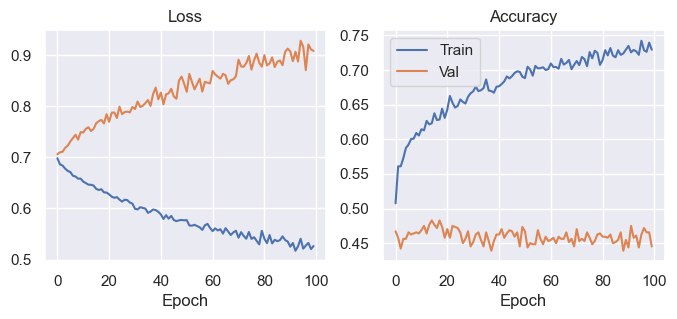

(0.7421875, 0.4828125, 0.44625)

In [24]:
binary_model_experiment(subset_same[subset_same['d'] < 25], 'pauli_zz_res', 10, verbose=True)